# Forward Error Correction Bit Error Analysis

In [1]:
from pynq import Overlay
import numpy as np
import xsdfec
import rfsoc_sdfec
import ipywidgets as ipw
from IPython.display import display
import time
import threading

from helper_functions import *

ol = Overlay('bitstream/fec_ber.bit')

## Configure Encoder & Decoder

In [2]:
# Initialise encoder hardware
e_fec = ol.sd_fec_enc
e_ldpc_params = e_fec.available_ldpc_params()
add_multiple_ldpc_params(e_fec, e_ldpc_params)

# Initialise decoder hardware
d_fec = ol.sd_fec_dec
d_ldpc_params = d_fec.available_ldpc_params()
add_multiple_ldpc_params(d_fec, d_ldpc_params)

def set_ldpc_code(cn):
    e_code_id = e_ldpc_params.index(e_ldpc_params[cn])
    e_ctrl_params = {'id' : 0, 'code' : e_code_id}
    enc_ctrl = create_ctrl_reg(e_ctrl_params)
    k = e_fec._code_params.ldpc[e_ldpc_params[cn]]['k']
    p = e_fec._code_params.ldpc[e_ldpc_params[cn]]['p']
    print('Encoder (k,p): ', k, p)
    print('Max theoretical throughput: ', (p / np.ceil(p/128)) * 640, 'MHz')
    enc_length = int(k / 8)

    d_code_id = d_ldpc_params.index(d_ldpc_params[cn])
    d_ctrl_params = {'id' : 0, 
                     'max_iterations' : 32,
                     'term_on_no_change' : 1,
                     'term_on_pass' : 1, 
                     'include_parity_op' : 0,
                     'hard_op' : 1,
                     'code' : d_code_id}
    dec_ctrl = create_ctrl_reg(d_ctrl_params)
    dec_length = d_fec._code_params.ldpc[d_ldpc_params[cn]]['n']
    k = d_fec._code_params.ldpc[d_ldpc_params[cn]]['k']
    p = d_fec._code_params.ldpc[d_ldpc_params[cn]]['p']
    print('Decoder (k,p): ', k, p)
    print('Max theoretical throughput: ', (p / np.ceil(p/16)) * 640, 'MHz')
    
    ol.sd_fec_ctrl_encoder.set(enc_ctrl, enc_length)
    ol.sd_fec_ctrl_decoder.set(dec_ctrl, dec_length)
    
    return e_ldpc_params[cn] + ' / ' + d_ldpc_params[cn]

Adding LDPC code parameters to "sd_fec_enc" internal memory.

Status     Code ID    SC Offset  LA Offset  QC Offset  Code Name 
------     ------     ------     ------     ------     ------    
Loaded     0          0          0          0          docsis_short_encode
Loaded     1          2          2          21         docsis_medium_encode
Loaded     2          4          4          54         docsis_long_encode
Loaded     3          6          6          97         docsis_init_ranging_encode
Loaded     4          8          8          112        docsis_fine_ranging_encode
Adding LDPC code parameters to "sd_fec_dec" internal memory.

Status     Code ID    SC Offset  LA Offset  QC Offset  Code Name 
------     ------     ------     ------     ------     ------    
Loaded     0          0          0          0          docsis_short
Loaded     1          2          2          21         docsis_medium
Loaded     2          4          4          54         docsis_long
Loaded     3       

## Measure Bit Error Rate

In [3]:
import asyncio
import threading

class Interrupt():  
    def __init__(self, 
                 irq, 
                 irq_callback): 
        self._interrupt = irq
        self._irq_callback = irq_callback
        self._loop = asyncio.get_event_loop()
        self.is_running = False
        self.thread = None
        
    async def _wait(self):
        await self._interrupt.wait() # Wait for IRQ level
        self._irq_callback()
        
    def _do(self):
        while True:
            self.is_running = True
            future = asyncio.run_coroutine_threadsafe(self._wait(), self._loop)
            future.result()
        
    def start(self):
        """Start the async irq routine."""
        self.thread = threading.Thread(target=self._do)
        self.thread.start()
        
#     def stop(self):

In [4]:
# Create interrupt handler
def intr_handler():
    global intr_flag
    global running
#     if running == 1:
#         print('Too quick!!!')
    intr_flag = 1
    
# Main
def main():
    global intr_flag
    global running
    
    # Create Progress Bars
    layout = ipw.Layout(width='auto', height='40px')
    style = {'description_width': '300px'}
    codes_progress = ipw.IntProgress(min=0, 
                                 max=len(codes),
                                 description='Codes Progress: ',
                                 layout=layout,
                                 style=style)
    display(codes_progress)
    code_name = set_ldpc_code(codes[0])
    snr_progress = ipw.IntProgress(min=0, 
                               max=len(SNRs),
                               description='%s: ' % code_name,
                               layout=layout,
                               style=style)
    display(snr_progress)

    # Initialise Hardware
    ol.random_number_generator.set_signal_length(ol.sd_fec_ctrl_encoder.len * num_blocks)
    ol.awgn_channel.set_snr(SNRs[0])
    ol.soft_demodulation.set_scaling(ol.awgn_channel.noise_var, 0.3)
    ol.ber.length = ol.sd_fec_ctrl_encoder.len * num_blocks * 8
    
    # Run
    ol.random_number_generator.start()
    while(1):
        if intr_flag == 1:
#             running = 1
            intr_flag = 0
            
            # Counts
            bit_count.append(ol.ber.bit_count)
            fifo_count.append(ol.ber.fifo_num)
            
            # Get BER measurement
            ber = ol.ber.get_ber()
            BERs.append(ber)
            ol.ber.reset()
            
            # Get LLR measurement
            max_llrs.append(ol.soft_demodulation.llr_max)
            ol.soft_demodulation.mag_reset()
            
            snr_progress.value += 1

            # Break out loop when the final measurement has been recorded
            if snr_progress.value == len(SNRs):
                if codes_progress.value == len(codes)-1:
                    snr_progress.style.bar_color = 'green'
                    codes_progress.value += 1
                    codes_progress.style.bar_color = 'green'
                    break
                else:
                    running = 0
                    print(ol.ber.fifo_num)
                    codes_progress.value += 1
                    snr_progress.style.bar_color = 'green'
                    code_name = set_ldpc_code(codes[codes_progress.value])
                    snr_progress = ipw.IntProgress(min=0, 
                                                   max=len(SNRs),
                                                   description='%s: ' % code_name,
                                                   layout=layout,
                                                   style=style)
                    display(snr_progress)
                    ol.random_number_generator.set_signal_length(ol.sd_fec_ctrl_encoder.len * num_blocks)
                    ol.ber.length = ol.sd_fec_ctrl_encoder.len * num_blocks * 8
            
            # Set next SNR value
            snr = SNRs[snr_progress.value]
            ol.awgn_channel.set_snr(snr)
            ol.soft_demodulation.set_scaling(ol.awgn_channel.noise_var, 0.096875)

            # Start next signal to be measured
            # (this will result in the interrupt triggering after a period)
            ol.random_number_generator.start()

In [5]:
# Set Parameters
num_blocks = 1000
codes = [0,2,4]
SNRs = [x / 10.0 for x in range(200, 0, -10)]
BERs = []
max_llrs = []
bit_count = []
fifo_count = []

# Start
intr_flag = 0
running = 0
intr = Interrupt(irq=ol.ber.ber_intr,irq_callback=intr_handler)
intr.start()
main_thread = threading.Thread(target = main)
main_thread.start()

IntProgress(value=0, description='Codes Progress: ', layout=Layout(height='40px', width='auto'), max=3, style=…

Encoder (k,p):  840 56
Max theoretical throughput:  35840.0 MHz
Decoder (k,p):  840 56
Max theoretical throughput:  8960.0 MHz


IntProgress(value=0, description='docsis_short_encode / docsis_short: ', layout=Layout(height='40px', width='a…

0.0
Encoder (k,p):  14400 360
Max theoretical throughput:  76800.0 MHz
Decoder (k,p):  14400 360
Max theoretical throughput:  10017.391304347826 MHz


IntProgress(value=0, description='docsis_long_encode / docsis_long: ', layout=Layout(height='40px', width='aut…

0.0
Encoder (k,p):  288 48
Max theoretical throughput:  30720.0 MHz
Decoder (k,p):  288 48
Max theoretical throughput:  10240.0 MHz


IntProgress(value=0, description='docsis_fine_ranging_encode / docsis_fine_ranging: ', layout=Layout(height='4…

## BER

0 200
200 400
400 600


<function matplotlib.pyplot.show(*args, **kw)>

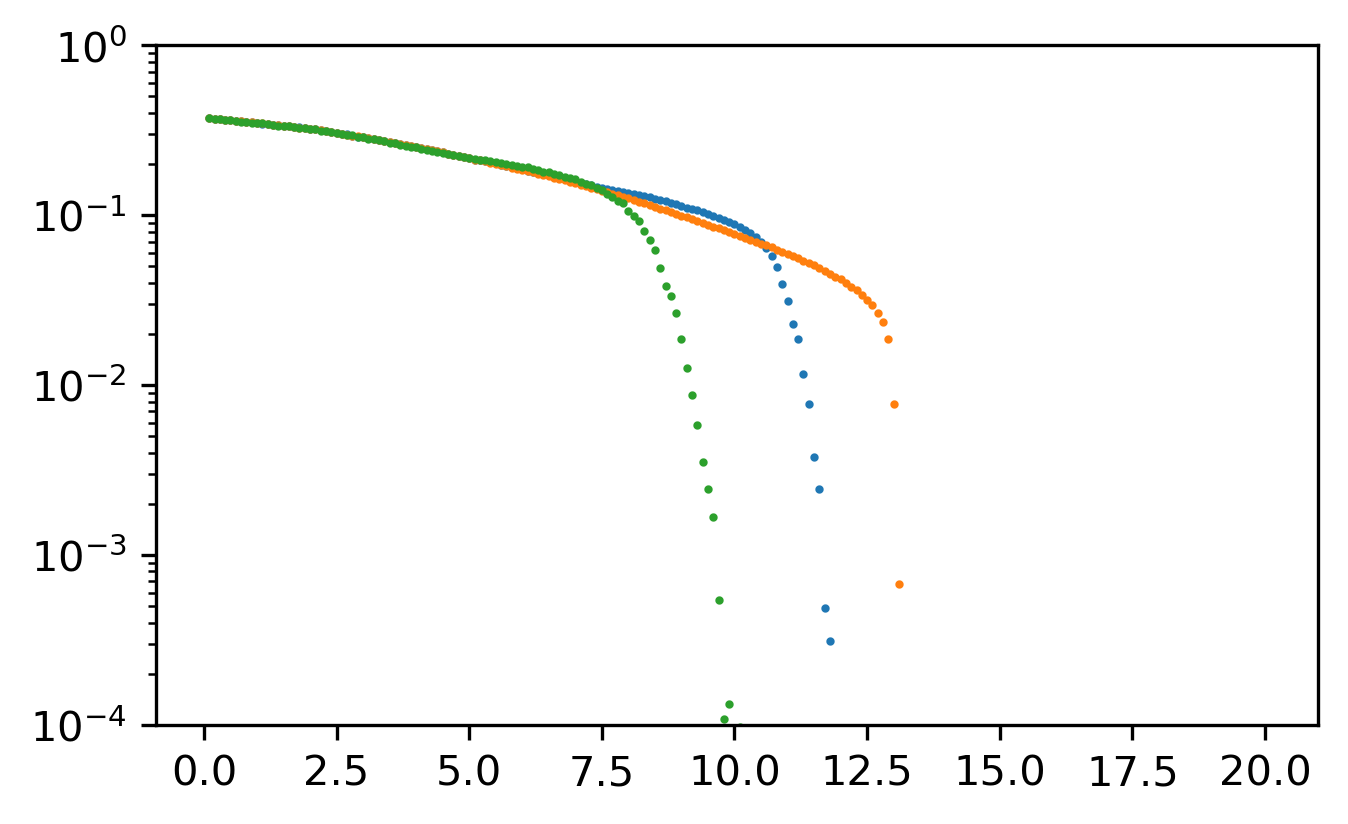

In [19]:
R = len(codes)
L = len(BERs)
for i in range(R):
    start = int(i*(L/R))
    end = int(((i+1)*(L/R)))
    print(start, end)
    plt.scatter(SNRs, BERs[start:end], s=1)
    
plt.yscale('log')
plt.ylim(top = 1, bottom = 0.0001)
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 300
plt.show

## FIFO Count

0 200
200 400
400 600


<function matplotlib.pyplot.show(*args, **kw)>

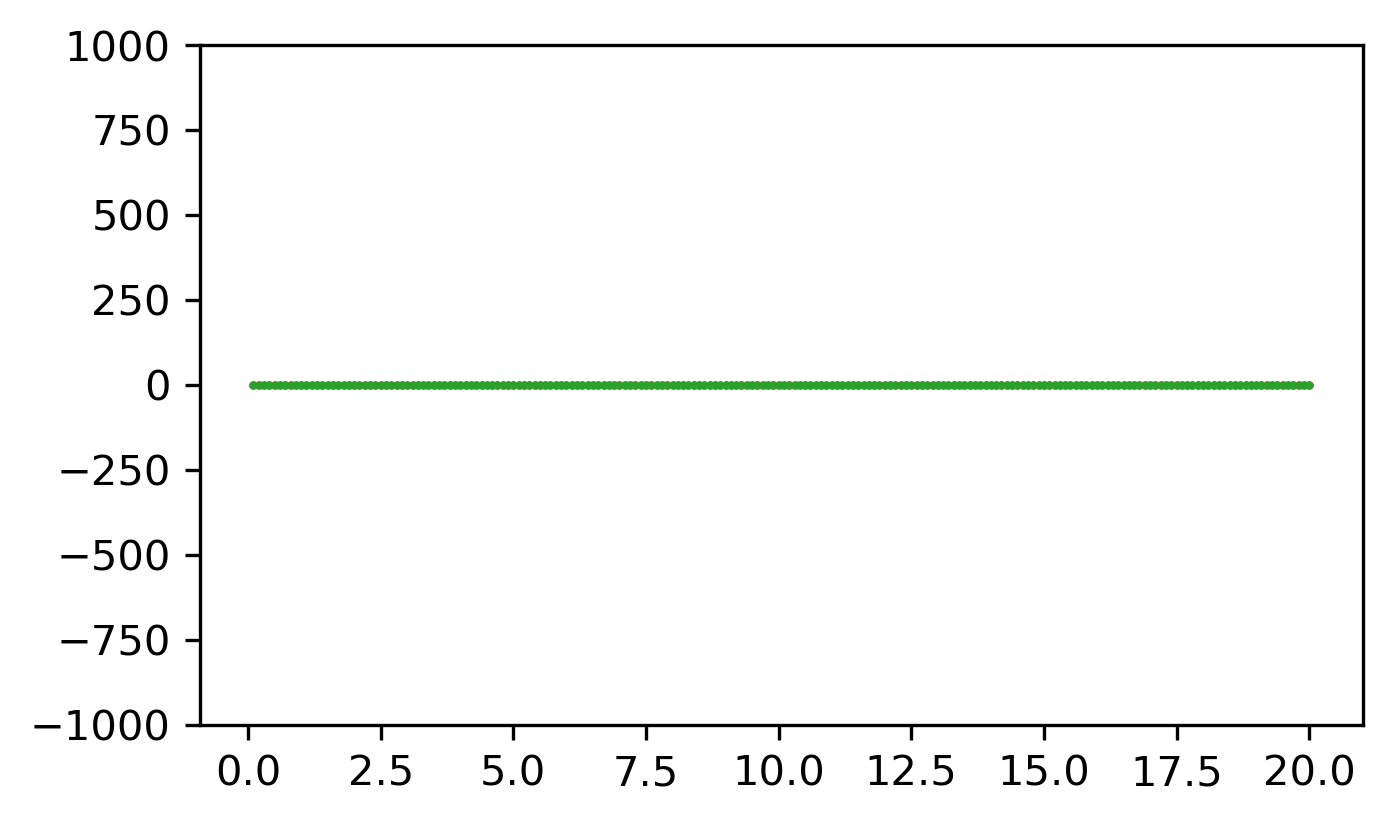

In [20]:
R = len(codes)
L = len(fifo_count)
for i in range(R):
    start = int(i*(L/R))
    end = int(((i+1)*(L/R)))
    print(start, end)
    plt.scatter(SNRs, fifo_count[start:end], s=1)
    
plt.ylim(top = max(fifo_count) + 1000, bottom = min(fifo_count)-1000)
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 300
plt.show

## Bit Count

0 200
200 400
400 600


<function matplotlib.pyplot.show(*args, **kw)>

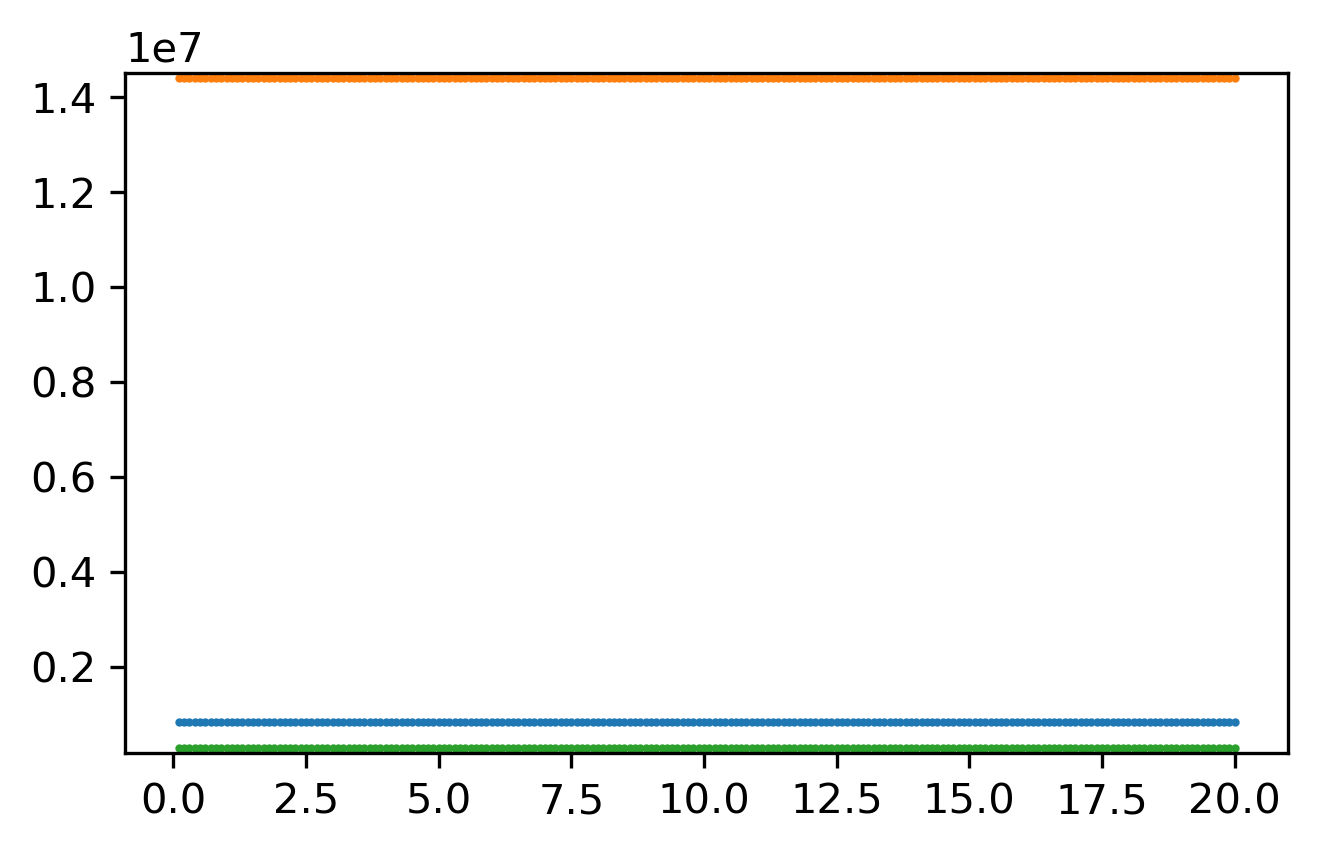

In [21]:
R = len(codes)
L = len(bit_count)
for i in range(R):
    start = int(i*(L/R))
    end = int(((i+1)*(L/R)))
    print(start, end)
    plt.scatter(SNRs, bit_count[start:end], s=1)
    
plt.ylim(top = max(bit_count) + 100000, bottom = min(bit_count)-100000)
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 300
plt.show

## LLRs

0 200
200 400
400 600


<function matplotlib.pyplot.show(*args, **kw)>

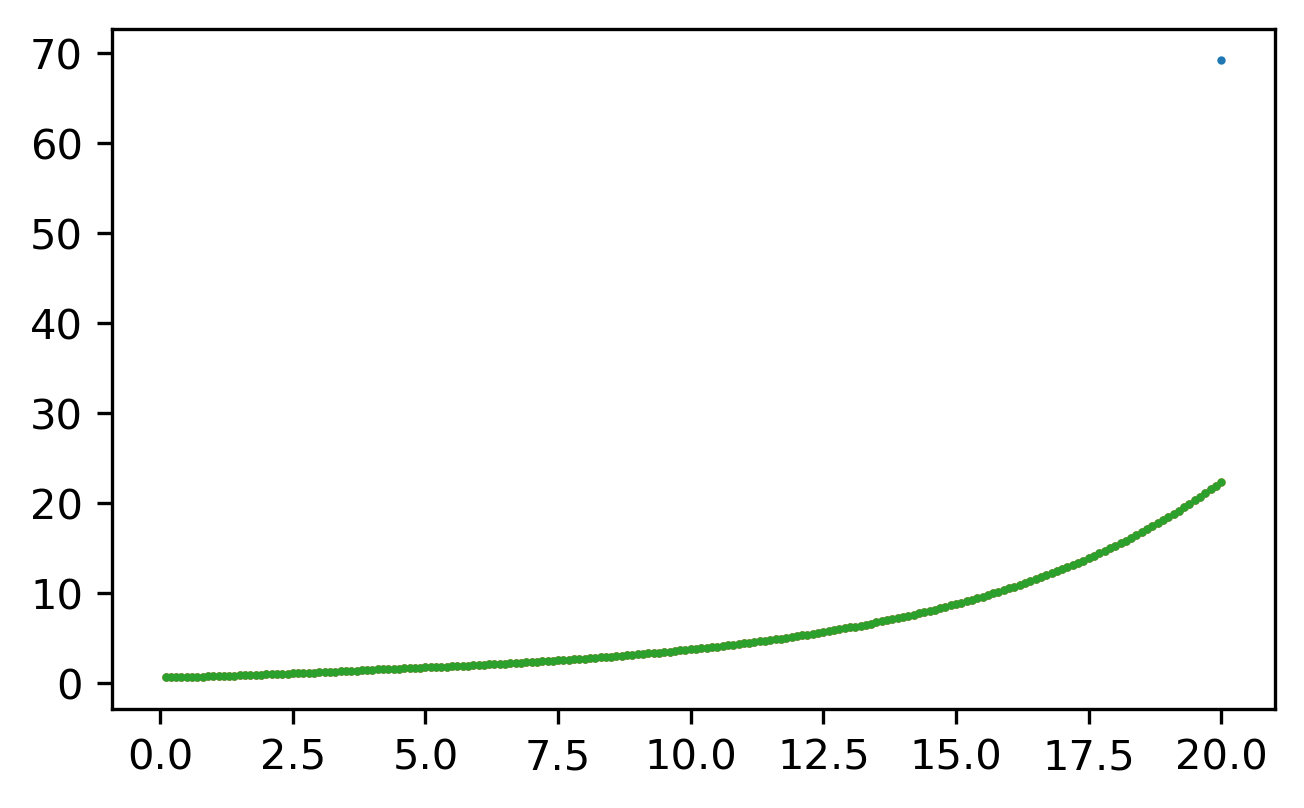

In [22]:
R = len(codes)
L = len(max_llrs)
for i in range(R):
    start = int(i*(L/R))
    end = int(((i+1)*(L/R)))
    print(start, end)
    plt.scatter(SNRs, max_llrs[start:end], s=1)
    
# plt.ylim(top = 10, bottom = 0)
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 300
plt.show